In [1]:
!pip install torchvision

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


torch.manual_seed(12046)

dataset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transforms.ToTensor())

In [4]:
x, y = dataset[21]
x.shape

torch.Size([1, 28, 28])

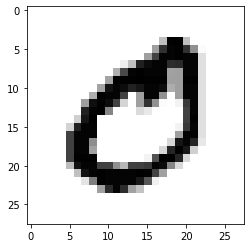

In [6]:
plt.imshow(x.squeeze(0).numpy(), cmap=plt.cm.binary)

In [7]:
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./mnist', train=False, download=True, transform=transforms.ToTensor())

In [8]:
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = DataLoader(val_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=True)

In [10]:
x, y = next(iter(train_loader))
x.shape, y.shape, x.view(x.shape[0], -1).shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]), torch.Size([500, 784]))

In [18]:
class MLP(nn.Module):
    
    def __init__(self):
        pass
    
    def forward(self, x):
        pass
    
model = MLP()

model = nn.Sequential(
    nn.Linear(784, 30), nn.Sigmoid(),
    nn.Linear( 30, 20), nn.Sigmoid(),
    nn.Linear( 20, 10)
)

In [52]:
eval_iters = 10


def estimate_loss(model):
    re = {}
    # 将模型切换为评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['val'] = _loss(model, val_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换为训练模式
    model.train()
    return re

    
@torch.no_grad()
def _loss(model, dataloader):
    # 估算模型效果
    loss = []
    acc = []
    data_iter = iter(dataloader)
    for t in range(eval_iters):
        inputs, labels = next(data_iter)
        # inputs: (500, 1, 28, 28)
        # labels: (500)
        B, C, H, W = inputs.shape
        logits = model(inputs.view(B, -1))
        loss.append(F.cross_entropy(logits, labels))
        # preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
        preds = torch.argmax(logits, dim=-1)
        acc.append((preds == labels).sum() / B)
    re = {
        'loss': torch.tensor(loss).mean().item(),
        'acc': torch.tensor(acc).mean().item()
    }
    return re

In [12]:
preds = torch.randint(4, (6, ))
labels = torch.randint(4, (6, ))
preds, labels

(tensor([3, 3, 3, 2, 3, 1]), tensor([1, 1, 0, 2, 3, 3]))

In [15]:
(preds == labels).sum()

tensor(2)

In [22]:
estimate_loss(model)

{'train': {'loss': 2.346519947052002, 'acc': 0.1096000075340271},
 'val': {'loss': 2.345228672027588, 'acc': 0.10600000619888306},
 'test': {'loss': 2.342650890350342, 'acc': 0.11500000953674316}}

In [54]:
def train_model(model, optimizer, epochs=10, penalty=False):
    lossi = []
    for e in range(epochs):
        for data in train_loader:
            inputs, labels = data
            B, C, H, W = inputs.shape
            logits = model(inputs.view(B, -1))
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            if penalty:
                w = torch.cat([p.view(-1) for p in model.parameters()])
                loss += 0.001 * w.abs().sum() + 0.002 * w.square().sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        stats = estimate_loss(model)
        train_loss = f'{stats["train"]["loss"]:.3f}'
        val_loss = f'{stats["val"]["loss"]:.3f}'
        test_loss = f'{stats["test"]["loss"]:.3f}'
        print(f'epoch {e} train {train_loss} val {val_loss} test {test_loss}')
    return lossi

In [28]:
loss = {}

In [32]:
model = nn.Sequential(
    nn.Linear(784, 30), nn.Sigmoid(),
    nn.Linear( 30, 20), nn.Sigmoid(),
    nn.Linear( 20, 10)
)

loss['mlp'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.317 val 2.316 test 2.313
epoch 1 train 2.306 val 2.304 test 2.304
epoch 2 train 2.301 val 2.303 test 2.302
epoch 3 train 2.300 val 2.300 test 2.301
epoch 4 train 2.299 val 2.301 test 2.301
epoch 5 train 2.299 val 2.300 test 2.299
epoch 6 train 2.298 val 2.300 test 2.298
epoch 7 train 2.298 val 2.299 test 2.298
epoch 8 train 2.298 val 2.299 test 2.299
epoch 9 train 2.296 val 2.297 test 2.297


In [33]:
model = nn.Sequential(
    nn.Linear(784, 30), nn.ReLU(),
    nn.Linear( 30, 20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.286 val 2.287 test 2.287
epoch 1 train 2.249 val 2.248 test 2.246
epoch 2 train 2.191 val 2.189 test 2.187
epoch 3 train 2.110 val 2.106 test 2.104
epoch 4 train 1.976 val 1.974 test 1.971
epoch 5 train 1.786 val 1.781 test 1.783
epoch 6 train 1.539 val 1.526 test 1.524
epoch 7 train 1.277 val 1.278 test 1.271
epoch 8 train 1.072 val 1.072 test 1.076
epoch 9 train 0.955 val 0.936 test 0.947


In [35]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 1.449 val 1.457 test 1.450
epoch 1 train 1.072 val 1.074 test 1.054
epoch 2 train 0.801 val 0.803 test 0.790
epoch 3 train 0.617 val 0.637 test 0.615
epoch 4 train 0.511 val 0.514 test 0.502
epoch 5 train 0.420 val 0.435 test 0.430
epoch 6 train 0.370 val 0.397 test 0.369
epoch 7 train 0.332 val 0.340 test 0.332
epoch 8 train 0.317 val 0.319 test 0.308
epoch 9 train 0.279 val 0.298 test 0.280


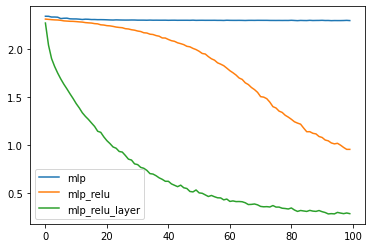

In [38]:
for i in ['mlp', 'mlp_relu', 'mlp_relu_layer']:
    plt.plot(torch.tensor(loss[i]).view(-1, 10).mean(dim=-1), label=i)
plt.legend()
plt.show()

In [39]:
# 模型过拟合
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.200 val 0.197 test 0.217
epoch 1 train 0.129 val 0.157 test 0.147
epoch 2 train 0.100 val 0.133 test 0.140
epoch 3 train 0.088 val 0.142 test 0.125
epoch 4 train 0.088 val 0.142 test 0.139
epoch 5 train 0.075 val 0.137 test 0.132
epoch 6 train 0.063 val 0.139 test 0.120
epoch 7 train 0.059 val 0.118 test 0.119
epoch 8 train 0.056 val 0.133 test 0.119
epoch 9 train 0.055 val 0.118 test 0.125
epoch 10 train 0.046 val 0.112 test 0.135
epoch 11 train 0.042 val 0.128 test 0.122
epoch 12 train 0.039 val 0.127 test 0.147
epoch 13 train 0.044 val 0.115 test 0.126
epoch 14 train 0.031 val 0.116 test 0.120
epoch 15 train 0.031 val 0.134 test 0.133
epoch 16 train 0.027 val 0.117 test 0.137
epoch 17 train 0.024 val 0.135 test 0.117
epoch 18 train 0.027 val 0.141 test 0.145
epoch 19 train 0.027 val 0.133 test 0.178


In [40]:
m = nn.Dropout(0.5)
x = torch.randn(5, requires_grad=True)

In [43]:
x

tensor([ 1.3846,  0.5061,  0.3079,  1.1239, -1.9939], requires_grad=True)

In [50]:
m.train()
l = m(x)
l.sum().backward()
l, x.grad

(tensor([0.0000, 1.0123, 0.0000, 0.0000, -0.0000], grad_fn=<MulBackward0>),
 tensor([0., 4., 2., 0., 0.]))

In [48]:
m.eval()
m(x)

tensor([ 1.3846,  0.5061,  0.3079,  1.1239, -1.9939], requires_grad=True)

In [51]:
m.training

True

In [53]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer_dropout'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.265 val 0.260 test 0.261
epoch 1 train 0.182 val 0.200 test 0.204
epoch 2 train 0.153 val 0.187 test 0.196
epoch 3 train 0.161 val 0.184 test 0.173
epoch 4 train 0.179 val 0.178 test 0.170
epoch 5 train 0.134 val 0.167 test 0.162
epoch 6 train 0.122 val 0.171 test 0.164
epoch 7 train 0.124 val 0.157 test 0.157
epoch 8 train 0.116 val 0.160 test 0.149
epoch 9 train 0.128 val 0.154 test 0.158
epoch 10 train 0.104 val 0.153 test 0.147
epoch 11 train 0.121 val 0.153 test 0.149
epoch 12 train 0.117 val 0.142 test 0.158
epoch 13 train 0.099 val 0.143 test 0.151
epoch 14 train 0.110 val 0.159 test 0.139
epoch 15 train 0.110 val 0.159 test 0.138
epoch 16 train 0.105 val 0.138 test 0.151
epoch 17 train 0.096 val 0.131 test 0.142
epoch 18 train 0.089 val 0.153 test 0.156
epoch 19 train 0.106 val 0.155 test 0.164


In [56]:
# 惩罚项
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), 
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), 
    nn.Linear( 20, 10)
)

_ = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20, penalty=True)

epoch 0 train 0.286 val 0.292 test 0.287
epoch 1 train 0.256 val 0.253 test 0.235
epoch 2 train 0.247 val 0.261 test 0.242
epoch 3 train 0.218 val 0.241 test 0.218
epoch 4 train 0.211 val 0.220 test 0.205
epoch 5 train 0.227 val 0.235 test 0.227
epoch 6 train 0.219 val 0.243 test 0.231
epoch 7 train 0.209 val 0.233 test 0.217
epoch 8 train 0.215 val 0.210 test 0.201
epoch 9 train 0.205 val 0.208 test 0.204
epoch 10 train 0.262 val 0.279 test 0.249
epoch 11 train 0.200 val 0.221 test 0.208
epoch 12 train 0.208 val 0.237 test 0.212
epoch 13 train 0.219 val 0.226 test 0.206
epoch 14 train 0.209 val 0.222 test 0.216
epoch 15 train 0.194 val 0.236 test 0.215
epoch 16 train 0.204 val 0.212 test 0.206
epoch 17 train 0.213 val 0.231 test 0.208
epoch 18 train 0.202 val 0.232 test 0.211
epoch 19 train 0.228 val 0.247 test 0.236


In [57]:
estimate_loss(model)

{'train': {'loss': 0.21390601992607117, 'acc': 0.9363999366760254},
 'val': {'loss': 0.26335230469703674, 'acc': 0.9261999130249023},
 'test': {'loss': 0.24580919742584229, 'acc': 0.928600013256073}}